# 프로젝트 : Finance Time Series

# # Data Labeling

In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='time'>

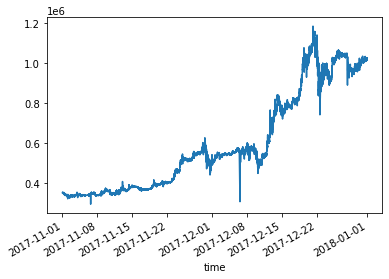

In [41]:
# 데이터 경로
DATA_PATH = '/aiffel/aiffel/fnguide/data/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

In [42]:
window = 10 

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

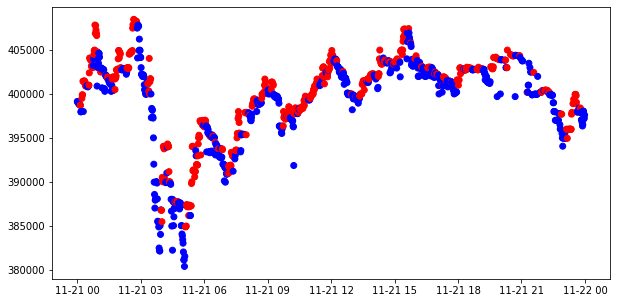

In [43]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [44]:
# momentum_signal 
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

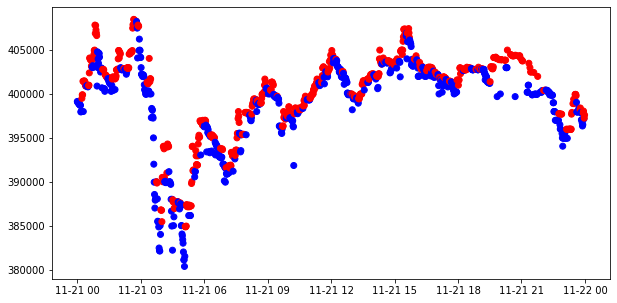

In [45]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [46]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [47]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인 
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

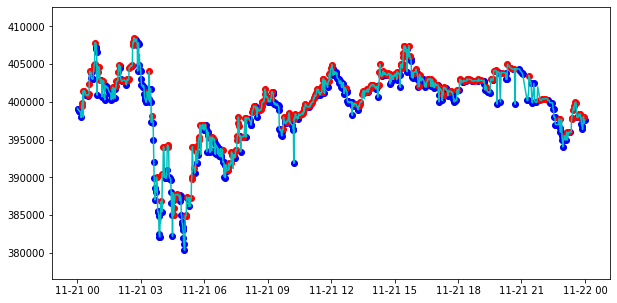

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

In [49]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [50]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [51]:
molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [13:17<00:00, 41.86it/s]


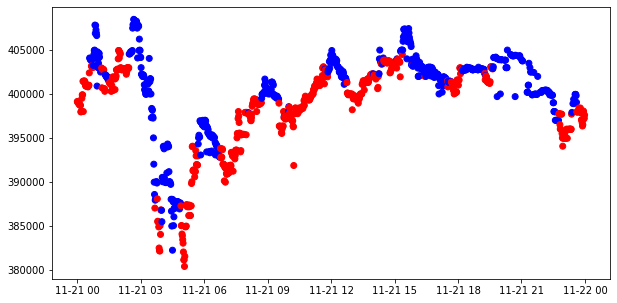

In [52]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

# Feature Engineering

In [53]:
!pip install ta==0.9.0
!pip install shap

In [54]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [55]:
# 데이터 경로 설정
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

In [56]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [57]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [58]:
df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1]

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [59]:
# RandomForest 모델 적용
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_sc, y)

# RandomForest fit 하기
RandomForestClassifier(class_weight='balanced')

RandomForestClassifier(class_weight='balanced')

In [60]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.044003,0.001934
volume_fi,0.048363,0.002449
volume_mfi,0.048475,0.002459
volume_sma_em,0.034419,0.001764
volume_vpt,0.025268,0.001508
volatility_atr,0.076452,0.003050
volatility_ui,0.048166,0.002770
trend_macd_diff,0.081034,0.004011
trend_adx,0.057052,0.002400
trend_trix,0.070285,0.003091


In [61]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [62]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

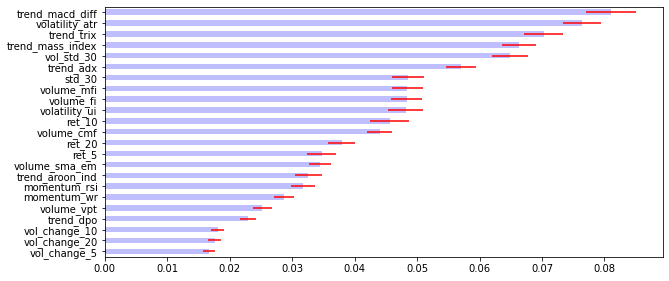

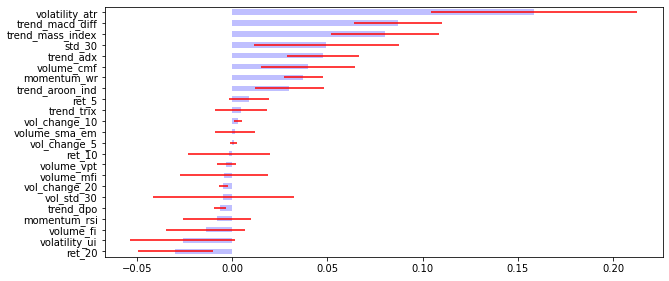

In [63]:
# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

In [64]:
# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

In [65]:
# 선택된 피쳐 확인하기
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


In [66]:
# SFS, Sequential Feature Selection

n = 2
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [67]:
# 선택된 피쳐 확인하기
sfs_df = pd.DataFrame([sfs_fitted.support_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
sfs_df

,Optimal_Features
volume_cmf,False
volume_fi,False
volume_mfi,True
volume_sma_em,False
volume_vpt,False
volatility_atr,False
volatility_ui,False
trend_macd_diff,True
trend_adx,False
trend_trix,False


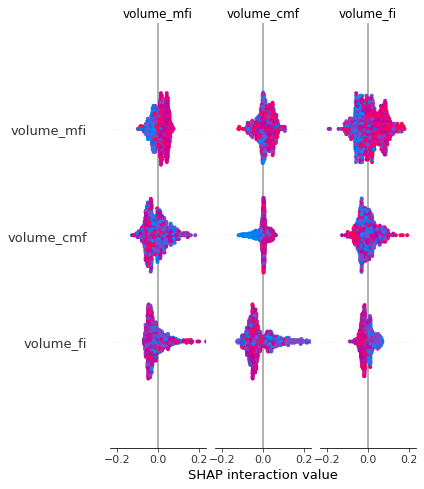

In [68]:
# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value, X_sc)

# Model Traning

In [69]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [70]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

# pickle 파일 불러오기
df_data = pd.read_pickle(data_file_name)  # df_data에 DataFrame 할당

# DataFrame 확인 (중간 점검)
print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 908845 entries, 2018-01-01 00:43:00 to 2019-11-03 10:03:00
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   open              908845 non-null  int64  
 1   high              908845 non-null  int64  
 2   low               908845 non-null  int64  
 3   close             908845 non-null  int64  
 4   volume            908845 non-null  float64
 5   volume_cmf        908845 non-null  float64
 6   volume_fi         908845 non-null  float64
 7   volume_mfi        908845 non-null  float64
 8   volume_sma_em     908845 non-null  float64
 9   volume_vpt        908845 non-null  float64
 10  volatility_atr    908845 non-null  float64
 11  volatility_ui     908845 non-null  float64
 12  trend_macd_diff   908845 non-null  float64
 13  trend_adx         908845 non-null  float64
 14  trend_trix        908845 non-null  float64
 15  trend_mass_index  908845 non-null 

In [71]:
print(df_data.head())

                        open     high      low    close     volume  \
time                                                                 
2018-01-01 00:43:00  1017500  1019000  1017500  1018500  30.272135   
2018-01-01 00:44:00  1018500  1021500  1018000  1021500  25.131162   
2018-01-01 00:45:00  1021500  1022000  1020000  1020000  17.108609   
2018-01-01 00:46:00  1020000  1025000  1019000  1025000  44.289130   
2018-01-01 00:47:00  1020000  1020000  1019000  1019000  10.224255   

                     volume_cmf     volume_fi  volume_mfi  volume_sma_em  \
time                                                                       
2018-01-01 00:43:00    0.363435    719.550725   56.072055   8.940793e+11   
2018-01-01 00:44:00    0.368141  10053.792799   54.776628   2.480511e+12   
2018-01-01 00:45:00    0.365340   5589.204549   56.034287   3.376449e+12   
2018-01-01 00:46:00    0.358534  32571.260299   50.196394   2.908715e+12   
2018-01-01 00:47:00    0.327429  20831.661354   45.44

In [72]:
# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

-1.0    306630
-0.0    302946
 1.0    299269
Name: t_value, dtype: int64

In [73]:
# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

# X와 y 데이터 분리
X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]  # 특성과 레이블 분리

# 데이터 스케일링 (StandardScaler 적용)
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x = X_sc[:n_train, :], X_sc[-n_test:, :]
train_y, test_y = y.iloc[:n_train], y.iloc[-n_test:]

# DataFrame으로 변환 (중간 확인)
train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 🛠️ 여러 차례 경험한, 무한정 걸리는 실행시간을 단축하고 아쉽지만 데이터셋 제한
train_x = train_x[:1000]   
train_y = train_y[:1000]   

In [74]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold
cv = PKFold(n_cv, t1, 0)

In [75]:
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [3,5,10,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

In [76]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [77]:
# Bagging 적용
bag_rfc = BaggingClassifier(rfc)

In [78]:
# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(train_x, train_y)
gs_rfc_best = gs_rfc.best_estimator_

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


In [84]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)  # 예측 수행
prob_y = gs_rfc_best.predict_proba(test_x)

In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)  # 예측 수행
prob_y = gs_rfc_best.predict_proba(test_x)  # 예측 확률 수행 (쉼표 문제 해결)

# 🧮 test_y, pred_y를 활용한 평가 메트릭스 계산
confusion = confusion_matrix(test_y, pred_y)  # 혼동 행렬
accuracy  = accuracy_score(test_y, pred_y)  # 정확도
precision = precision_score(test_y, pred_y, average='macro')  # 정밀도 (평균 설정)
recall    = recall_score(test_y, pred_y, average='macro')  # 재현율 (평균 설정)

# 📢 지표를 통한 결과 확인
print('================= Confusion Matrix ====================')
print(confusion)
print('======================================================')
print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}')

================= Confusion Matrix ====================
[[ 6984 45554 12716]
 [ 5195 34328 16535]
 [ 4101 30902 25454]]
정확도: 0.3673, 정밀도: 0.4014, 재현율: 0.3801


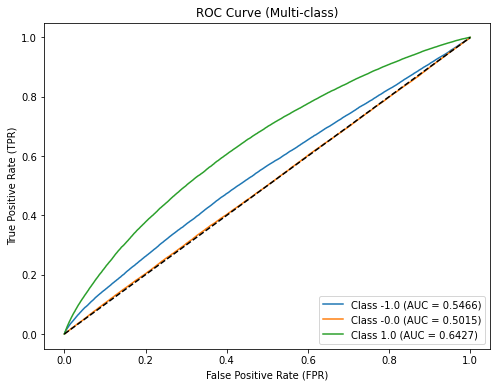

Overall AUC (macro-averaged): 0.5636


In [86]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# 🔥 다중 클래스에 맞게 Y 레이블을 이진화 (One-vs-Rest 방식)
# test_y에 있는 클래스를 원-핫 인코딩 형식으로 변환
classes = sorted(test_y.unique())  # 모든 고유 클래스 추출
test_y_bin = label_binarize(test_y, classes=classes)  # 다중 클래스 레이블을 이진화

# ✅ ROC Curve 및 AUC 점수 계산 (One-vs-Rest 방식)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):  # 각 클래스에 대해 별도의 ROC 커브 계산
    fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], prob_y[:, i])  # ROC 커브 계산
    roc_auc[i] = auc(fpr[i], tpr[i])  # AUC 계산

# 🧮 다중 클래스에 대해 전체 AUC 점수 계산
# multi_class='ovr'로 다중 클래스 AUC 점수 계산
overall_auc = roc_auc_score(test_y, prob_y, multi_class='ovr', average='macro')

# 📈 ROC Curve 시각화
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # 대각선 기준선
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (Multi-class)')
plt.legend(loc='lower right')
plt.show()

# 📢 AUC 점수 출력
print(f'Overall AUC (macro-averaged): {overall_auc:.4f}')
